In [1]:
from Utils.files import mkExpDir
from dataset import dataloader
from model import Extracter
from loss.loss import get_loss_dict
from trainer import Trainer

import os
import torch
import torch.nn as nn
import numpy as np
import warnings
import glob
import time

from argparse import Namespace
from torchinfo import summary
from Utils.ploting import plot_results

warnings.filterwarnings('ignore')

# Args

In [2]:
from argparse import Namespace

In [3]:
args   = Namespace()

## log setting

In [4]:
args.save_dir      = 'test'
args.reset         =  True
args.log_file_name = 'reside_indoor.log'
args.logger_name   = 'reside_indoor'

## device setting

In [5]:
args.device        = 'cuda'
args.num_gpu       = 1      

## dataset setting

In [6]:
args.dataset           = 'RESIDE'                      
args.dataset_dir        = r'/home/esteban/Data/RESIDE-IN' 
args.num_workers       = 4
args.batch_size        = 1   
args.img_training_size = (620, 460)

## model setting

In [7]:
args.feats_by_level   = '64+128+256' # Num of features by level [lv1, lv2, lv3]
args.num_res_blocks   = '8+12+12+12' # Residual blocks for features [IFE, lv1, lv2, lv3]
args.num_grad_blocks  = '2+6+6+6'    # Residual blocks for features [IFE, lv1, lv2, lv3]

args.n_feats          = 64           # The number of channels in network
args.res_scale        = 1.0          # Residual scale
args.top_k            = 3            # Top K matches for each patch

args.kernel_size      = 3            # Patch Setting and Top Features Setting
args.stride_size      = 1
args.padding_size     = 1

args.GAN_type         = 'WGAN_GP'    # The type of GAN used in training
args.GAN_k            = 1            # Training discriminator k times when training generator once

args.rec_w            = 1.0         # The weight of reconstruction loss

## optimizer setting

In [8]:
args.beta1          = 0.9    # The beta1 in Adam optimizer
args.beta2          = 0.999  # The beta2 in Adam optimizer
args.eps            = 1e-8   # The eps in Adam optimizer

args.lr_rate_fe     = 1e-4   # Learning rate
args.lr_rate        = 1e-4   # Learning rate
args.lr_rate_dis    = 1e-4   # Learning rate of discriminator
args.decay          = 1e-4   # Learning rate decay type
args.gamma          = 0.5    # Learning rate decay factor for step decay

## training setting

In [9]:
args.num_init_epochs = 600  # The number of init epochs which are trained with only reconstruction loss
args.num_epochs      = 0    # The number of training epochs
args.print_every     = 600  # Print period
args.save_every      = 5    # Save period
args.val_every       = 5    # Validation period
args.show_every      = 5    # Plot Results


## evaluate / test / finetune setting
args.eval              = True                      # Evaluation mode
args.eval_save_results = False                     # Save each image during evaluation
args.model_path        = None                      # The path of model to evaluation
args.test              = False                     # Test mode

In [10]:
args.img_size          = (620, 460)
args.ref_as_refsr      = False

# Main



In [11]:
# make save_dir
_logger     = mkExpDir(args)

In [12]:
args.aumentation = False
_dataloader = dataloader.get_dataloader(args) if (not args.test) else None

In [13]:
len(_dataloader['train'].dataset.input_list), len(_dataloader['train'].dataset.ref_list)

(13990, 13990)

## device

In [14]:
device = torch.device(args.device) # Choose CPU or GPU
torch.cuda.set_device(0)           # Select GPI ID

## model

In [15]:
_model    = Extracter.Extracter(args).to(device)
_loss_all = get_loss_dict(args, _logger)
t         = Trainer(args, _logger, _dataloader, _model, _loss_all)

In [16]:
summary(_model)

Layer (type:depth-idx)                             Param #
Extracter                                          --
├─FE: 1-1                                          --
│    └─Sequential: 2-1                             --
│    │    └─Conv2d: 3-1                            1,792
│    │    └─ReLU: 3-2                              --
│    └─Sequential: 2-2                             --
│    │    └─Conv2d: 3-3                            36,928
│    │    └─ReLU: 3-4                              --
│    │    └─MaxPool2d: 3-5                         --
│    │    └─Conv2d: 3-6                            73,856
│    │    └─ReLU: 3-7                              --
│    └─Sequential: 2-3                             --
│    │    └─Conv2d: 3-8                            147,584
│    │    └─ReLU: 3-9                              --
│    │    └─MaxPool2d: 3-10                        --
│    │    └─Conv2d: 3-11                           295,168
│    │    └─ReLU: 3-12                             --
│ 

In [18]:
t.load(r'/home/esteban/2025/03-TTSR-INDOOR-DEFORMABLE/save_dir_reside_indoor_2025_part2/model/model_00050.pt')

[trainer.py file line:39] - INFO: load_model_path: /home/esteban/2025/03-TTSR-INDOOR-DEFORMABLE/save_dir_reside_indoor_2025_part2/model/model_00050.pt


In [19]:
import math
import numpy as np
import logging
import cv2
import os
import shutil

import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Save results
def prepare(sample_batched, device):
    for key in sample_batched.keys():
        sample_batched[key] = sample_batched[key].to(device)
    return sample_batched

def plot_results(model = None, dataloader = None, total_images = 5, save = False, epoch = 0, device = None, args = None) :
    i = 0
    for names, sample_batched in dataloader['test'] :
        sample_batched = prepare(sample_batched, device)
        lr             = sample_batched['LR']
        hr             = sample_batched['HR']
        ref            = sample_batched['Ref']
        ref_sr         = sample_batched['Ref_sr']
        
        print(names)

        model.eval()
        with torch.no_grad():
            sr, S, _, _, _ = model(lr = lr, ref = ref, refsr = ref_sr)
            sr_save = (sr+1.) * 127.5

            lr     = (lr     + 1) * 127.5
            hr     = (hr     + 1) * 127.5
            ref    = (ref    + 1) * 127.5
            ref_sr = (ref_sr + 1) * 127.5

            sr_save_ = np.transpose(sr_save[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
            lr_      = np.transpose(lr[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
            hr_      = np.transpose(hr[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
            ref_     = np.transpose(ref[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
            ref_sr_  = np.transpose(ref_sr[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)

            # plot

            names       = ['LR', 'Extracter', 'Ref', 'Ref_sr', 'Target']
            num_classes = len(names)

            fig, ax = plt.subplots(figsize = (50,20), nrows = 1, ncols = 5, sharex = True, sharey = True,)
            ax      = ax.flatten()

            ax[0].imshow(lr_)
            ax[0].set_xlabel(str(0) + ': '+ names[0])


            ax[1].imshow(sr_save_)
            ax[1].set_xlabel(str(1) + ': '+ names[1])

            ax[2].imshow(ref_)
            ax[2].set_xlabel(str(2) + ': '+ names[2])

            ax[3].imshow(ref_sr_)
            ax[3].set_xlabel(str(3) + ': '+ names[3])

            ax[4].imshow(hr_)
            ax[4].set_xlabel(str(4) + ': '+ names[4])


            ax[0].set_xticks([])
            ax[0].set_yticks([])
            plt.show()

            if save :
                # Save the full figure...
                fig.savefig(args.save_dir + '/model_' + str(epoch) + '_' + str(i) + '.png')

            map_ = sns.heatmap(S[0].detach().cpu().numpy()[0][0], linewidth=0)
            plt.show()
            if save :
                figure = map_.get_figure()    
                figure.savefig(args.save_dir + '/heatmap_' + str(epoch) + '_' + str(i) + '.png')

        if i == total_images - 1 : 
            return
        i += 1

('/home/esteban/Data/RESIDE-IN/test/GT/1400_1.png',)


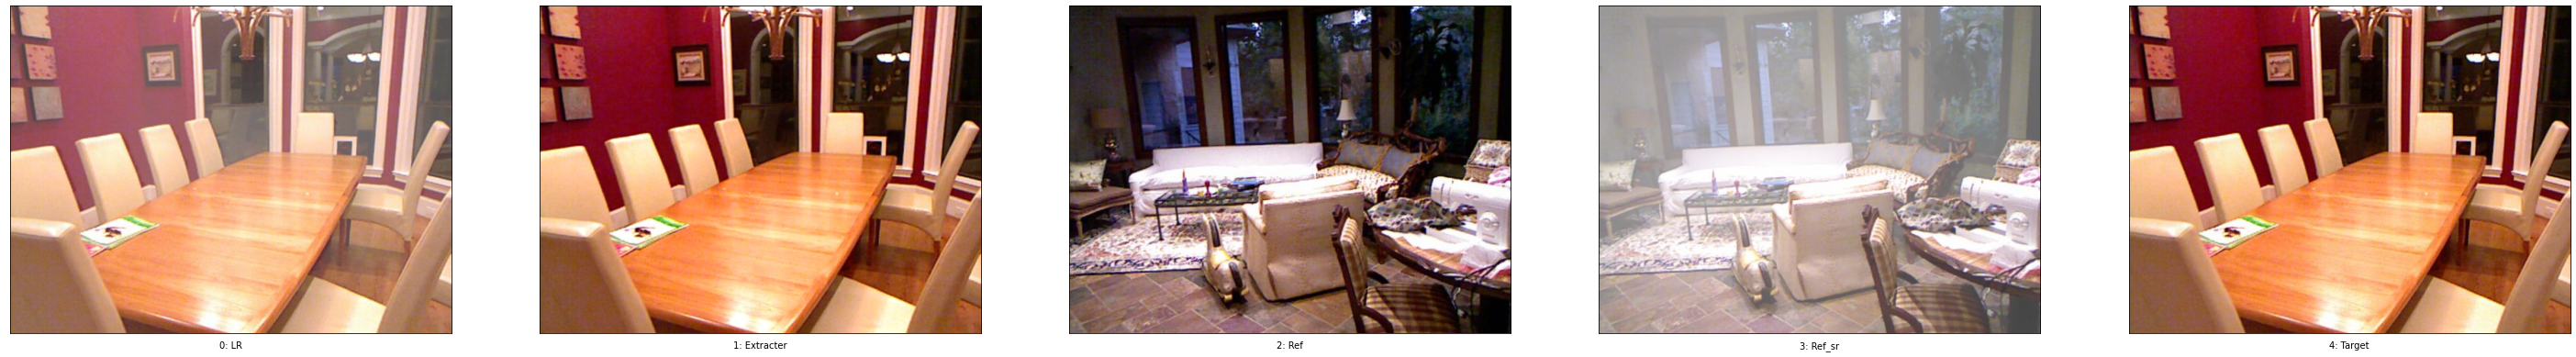

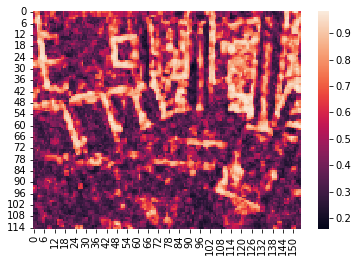

('/home/esteban/Data/RESIDE-IN/test/GT/1400_10.png',)


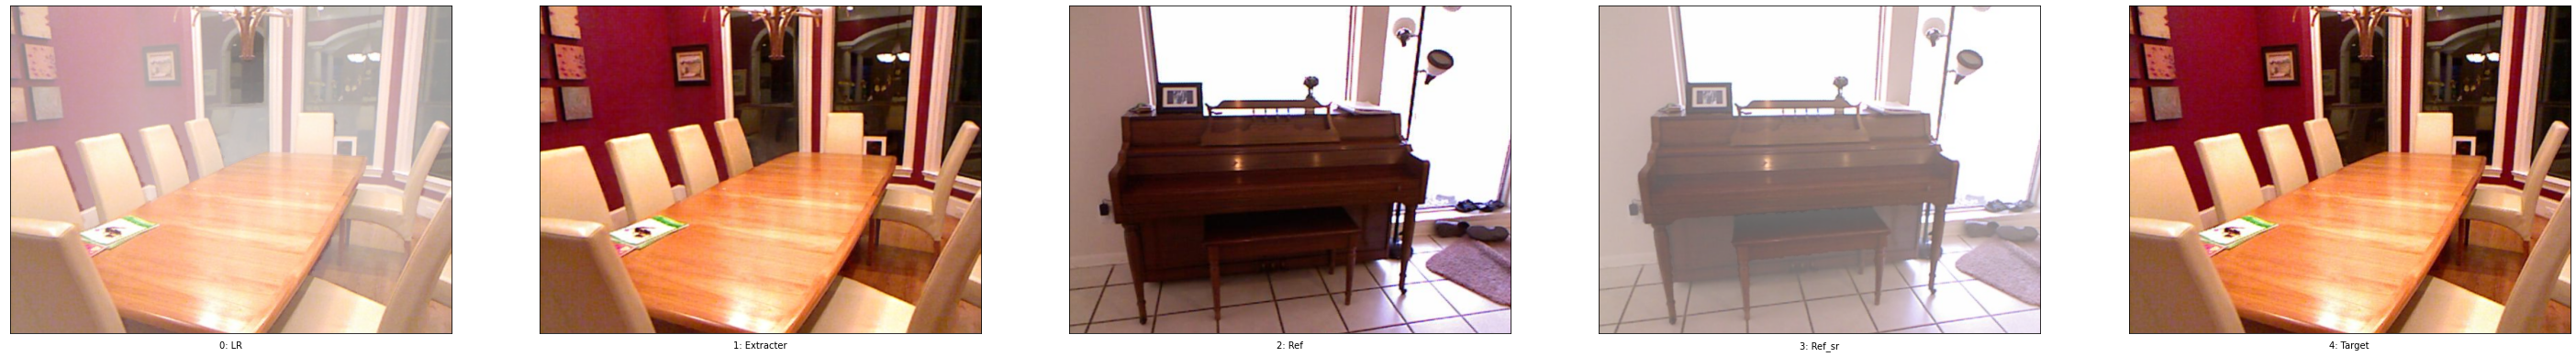

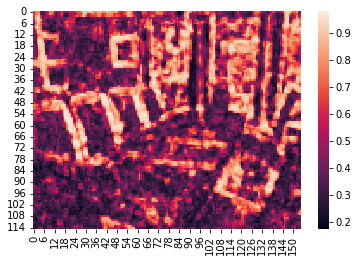

('/home/esteban/Data/RESIDE-IN/test/GT/1400_2.png',)


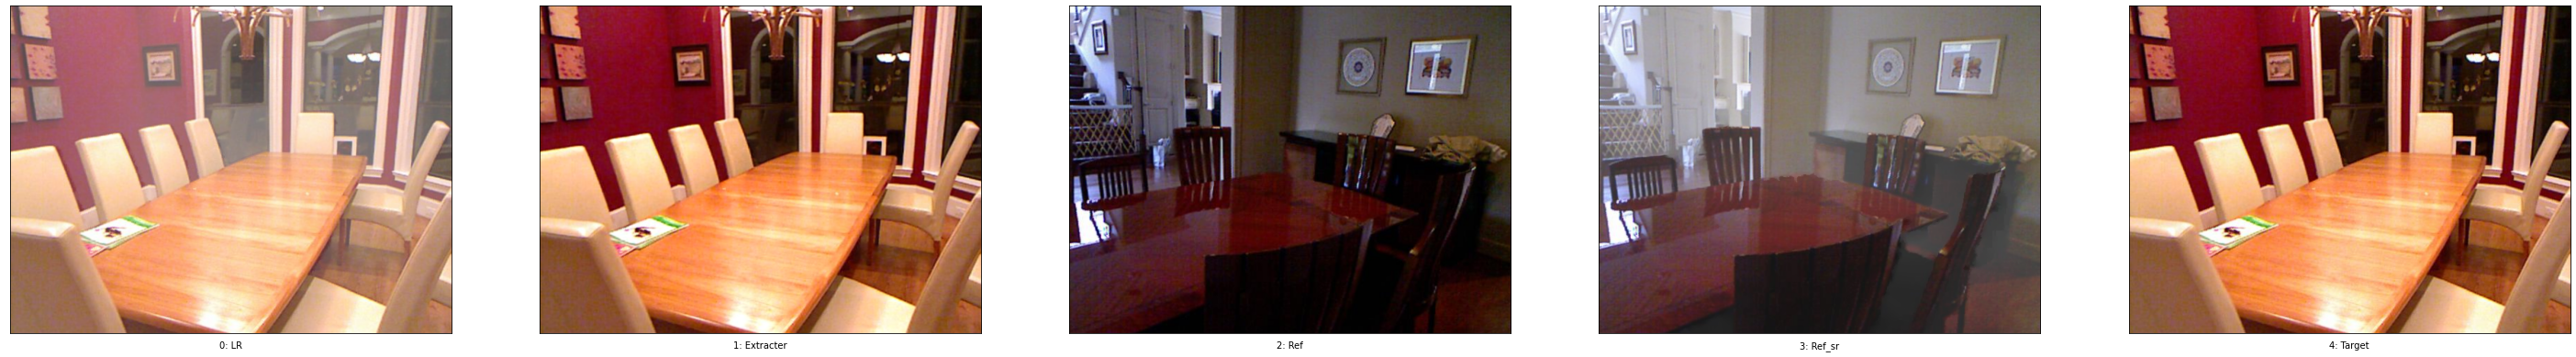

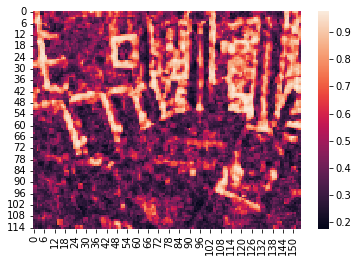

('/home/esteban/Data/RESIDE-IN/test/GT/1400_3.png',)


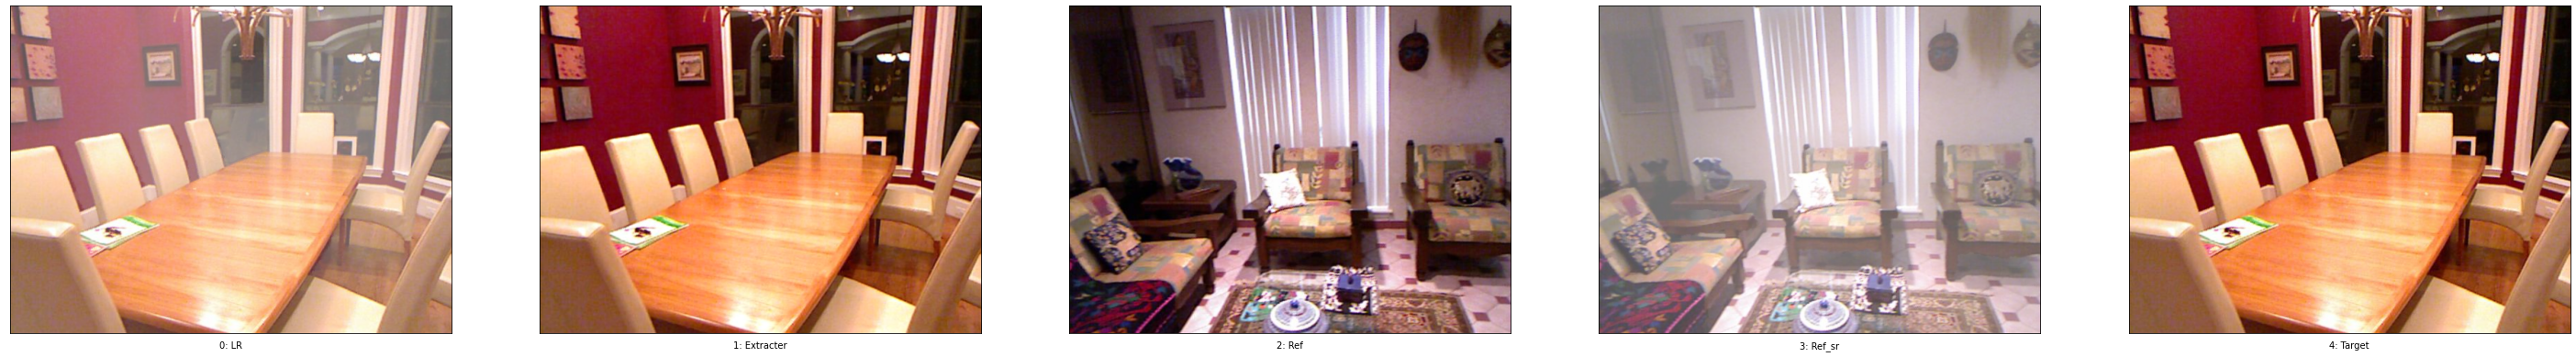

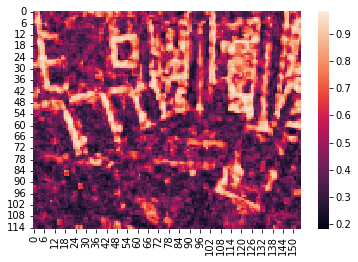

('/home/esteban/Data/RESIDE-IN/test/GT/1400_4.png',)


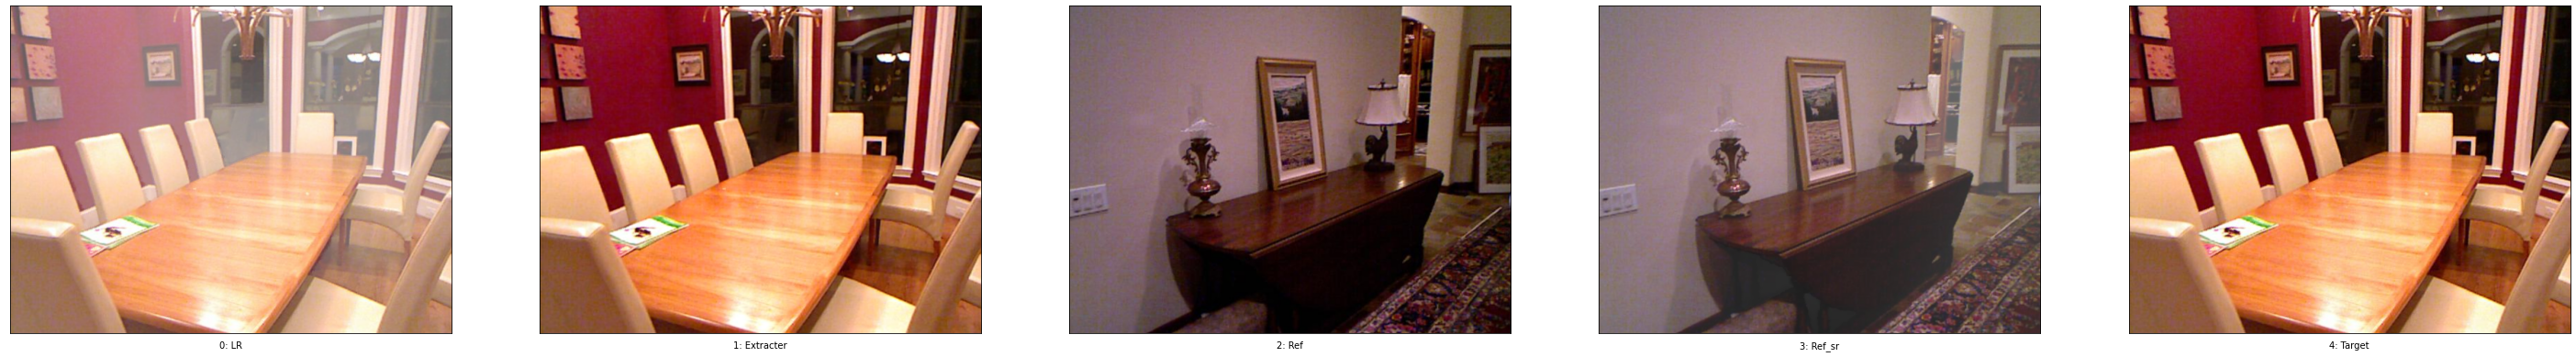

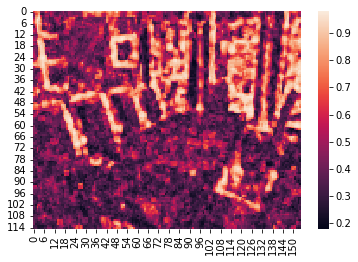

In [21]:
plot_results(model = t.model, dataloader = _dataloader, total_images = 5, save = False, epoch = 50, device = device, args = args)

In [22]:
t.evaluate(current_epoch = 50)

[trainer.py file line:108] - INFO: Epoch 50 evaluation process...
[trainer.py file line:185] - INFO: Ref  PSNR (now): 33.405 	 SSIM (now): 0.9881
[trainer.py file line:192] - INFO: Ref  PSNR (max): 33.405 (50) 	 SSIM (max): 0.9881 (50) 
[trainer.py file line:194] - INFO: Evaluation over.


In [20]:
import time

In [ ]:
for epoch in range(6, 50 + 1):        
    t.train(current_epoch=epoch)
    if (epoch % args.val_every == 0):
        t.evaluate(current_epoch = epoch)
    if (epoch % args.show_every == 0): 
        plot_results(model = t.model, dataloader = _dataloader, total_images = 5, save = True, epoch = epoch, device = device, args = args)

In [21]:
args.aumentation = True
t.dataloader     = dataloader.get_dataloader(args) if (not args.test) else None

In [ ]:
for epoch in range(51, args.num_init_epochs + 1):        
    t.train(current_epoch=epoch)
    if (epoch % args.val_every == 0):
        t.evaluate(current_epoch = epoch)
    if (epoch % args.show_every == 0): 
        plot_results(model = t.model, dataloader = _dataloader, total_images = 5, save = True, epoch = epoch, device = device, args = args)  

[trainer.py file line:68] - INFO: Current epoch learning rate: 5.000000e-05
[trainer.py file line:90] - INFO: epoch: 51	 batch: 600
[trainer.py file line:92] - INFO: rec_loss: 0.0424033031


In [ ]:
print("end")